## Basic Question-Generation Custom LLM Evaluation

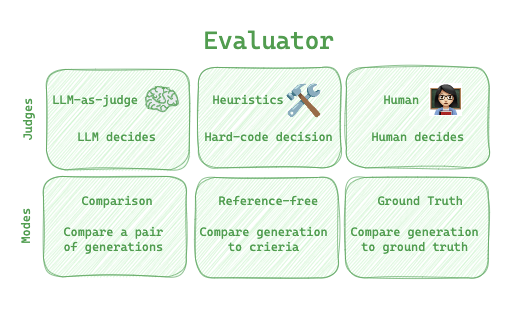

In [1]:
import pandas as pd
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_ollama import OllamaLLM
from langserve import RemoteRunnable
import mlflow
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec
from mlflow.metrics.genai import EvaluationExample


In [2]:
# !mlflow server --host 127.0.0.1 --port 5000

### CUSTOM LLM CLASS

In [3]:
## CUSTOM LLM CLASS TO EVALUATE
class CUSTOMLLM(mlflow.pyfunc.PythonModel):
    def load_context(self, context):
        self.model = OllamaLLM(
            model='llama3.1',
            temperature=0,
            # other params...
        )
        system_template = """
        Answer just with one question based on the user input.
        """
        prompt_template = ChatPromptTemplate.from_messages([
            ("system", system_template),
            MessagesPlaceholder(variable_name="messages")
        ])
        self.chain = prompt_template | self.model

    def predict(self, context, model_input):
        if not isinstance(model_input, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        
        if 'input' not in model_input.columns:
            raise ValueError("Input DataFrame must contain an 'input' column")

        input_text = model_input['input']
        predictions = []

        for text in input_text:
            messages = [("human", text)]
            generated_response = self.chain.invoke({"messages": messages})
            predictions.append(generated_response)

        # Create a DataFrame with predictions output and input
        predictions_df = pd.DataFrame({
            "input": input_text,
            "output": predictions
        })
        
        # Remove duplicate predictions while keeping the first occurrence to concatenate several output rows
        predictions_df = predictions_df.drop_duplicates(subset=['output'], keep='first')

        return predictions_df

In [4]:
# Define the model signature
input_schema = Schema([ColSpec("string", "input")])
output_schema = Schema([ColSpec("string", "prediction")])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

# Define an input example
input_example = pd.DataFrame({"input": ["Example of human input"]})

In [5]:
# Prepare evaluation data
eval_df = pd.DataFrame(
    {
        "input": [
            "The useEffect() hook in React is called after every render by default.",
            "Static members in a class belong to the class itself rather than to any specific instance of the class.",
            "In Python, the 'finally' block is executed regardless of whether an exception occurs or not.",
            "Multiprocessing involves running multiple processors in parallel, while multithreading involves executing multiple threads concurrently on a single processor.",
        ],
        "ground_truth": [
            "How does useEffect() work in React?",
            "What does the static keyword mean when used with class members?",
            "What is the purpose of the 'finally' block in Python?",
            "What is the difference between multiprocessing and multithreading?",
        ],
    }
)

In [6]:
## PARAMS
params = {
    'model_name': 'custom llm',
    'model_version': 0.1,
    'prompt': 'ejemplo del prompt',
    'prompt_version': 0.1,
    'input': eval_df['input'].tolist(),
    'ground_truth': eval_df['ground_truth'].tolist(),
}

In [7]:
## DEFINING CUSTOM METRICS
custom_metrics=[
    mlflow.metrics.latency(),
    mlflow.metrics.exact_match(),
    mlflow.metrics.ari_grade_level(),
    mlflow.metrics.flesch_kincaid_grade_level(),
    mlflow.metrics.token_count(),
    mlflow.metrics.rouge1(),
    mlflow.metrics.rouge2(),
]

In [8]:
## LOCAL METRICS
metrics = {
    'accuracy': 3,
}

In [9]:
## START THE EVALUATION
mlflow.set_experiment("TEST EVALUATION METRICS")
mlflow.set_tracking_uri(uri="http://localhost:5000/")

# Log the model and evaluate
with mlflow.start_run() as run:
    model_logged = mlflow.pyfunc.log_model(
        artifact_path=params['model_name'],
        python_model=CUSTOMLLM(),
        signature=signature,
        input_example=input_example,
    )
    
    results = mlflow.evaluate(
        model=mlflow.pyfunc.load_model(model_logged.model_uri),
        data=eval_df,
        targets="ground_truth",
        predictions='output',
        extra_metrics=custom_metrics,
    )

    mlflow.log_params(params)
    mlflow.log_metrics(metrics)
    mlflow.set_tag("tests evalutation", "telefonica")

2024/10/26 13:33:32 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/10/26 13:33:39 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/10/26 13:33:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run treasured-koi-837 at: http://localhost:5000/#/experiments/258677303853901222/runs/ddf2e455c7d646729e8bac0d0a98cdf7.
2024/10/26 13:33:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/258677303853901222.


In [10]:
# Test loaded model
loaded_model = mlflow.pyfunc.load_model(model_logged.model_uri)
response = loaded_model.predict(pd.DataFrame({'input': ['The cats brown, white and orange are female.']}))
response.iloc[0,1]

'Are you an expert in cat behavior or biology?'

In [11]:
# All the metrics
results.metrics

{'latency/mean': 1.8255046606063843,
 'latency/variance': 0.924617283537529,
 'latency/p90': 2.8820572376251223,
 'exact_match/v1': 0.0,
 'ari_grade_level/v1/mean': 8.450000000000001,
 'ari_grade_level/v1/variance': 13.752500000000001,
 'ari_grade_level/v1/p90': 11.92,
 'flesch_kincaid_grade_level/v1/mean': 8.149999999999999,
 'flesch_kincaid_grade_level/v1/variance': 9.747499999999999,
 'flesch_kincaid_grade_level/v1/p90': 10.58,
 'rouge1/v1/mean': 0.12118403164009392,
 'rouge1/v1/variance': 0.008214414666831826,
 'rouge1/v1/p90': 0.21362007168458783,
 'rouge2/v1/mean': 0.0,
 'rouge2/v1/variance': 0.0,
 'rouge2/v1/p90': 0.0}

In [12]:
# Table from metrics to export
results.tables["eval_results_table"]

,input,ground_truth,output,latency,ari_grade_level/v1/score,flesch_kincaid_grade_level/v1/score,token_count,rouge1/v1/score,rouge2/v1/score
0,The useEffect() hook in React is called after ...,How does useEffect() work in React?,"So, what's the purpose of the optional second ...",3.460084,12.7,10.7,26,0.068966,0
1,Static members in a class belong to the class ...,What does the static keyword mean when used wi...,"So, if you modify a static member in one insta...",1.533329,8.4,8.7,23,0.193548,0
2,"In Python, the 'finally' block is executed reg...",What is the purpose of the 'finally' block in ...,Is that true for all types of exceptions?,1.012475,2.6,2.9,9,0.222222,0
3,Multiprocessing involves running multiple proc...,What is the difference between multiprocessing...,"So if a system has only one processor, would i...",1.296131,10.1,10.3,20,0.000000,0


In [ ]:
## MODEL REGISTRY
# You can register the model if you are conform with the current evaluation
with mlflow.start_run(run_id=model_logged.run_id):
    mlflow.register_model(model_uri=model_logged.model_uri, name=params['model_name'])

### WRAPPER LLM CLASS

In [13]:
## CUSTOM LLM CLASS TO EVALUATE
class WRAPPERLLM(mlflow.pyfunc.PythonModel):
    def __init__(self, uri, thread_id):
        self.uri = uri
        self.thread_id = thread_id
        self.model = None
        self.config = None

    def load_context(self, context):
        self.model = RemoteRunnable(self.uri)
        self.config = {"configurable": {"thread_id": self.thread_id}}

    def predict(self, context, model_input):
        if not isinstance(model_input, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        
        if 'input' not in model_input.columns:
            raise ValueError("Input DataFrame must contain an 'input' column")

        input_text = model_input['input']
        
        predictions = []
        for text in input_text:
            messages = [("human", text)]
            response = self.model.invoke({"messages": messages}, self.config)
            generated_response = response["messages"][-1].content
            predictions.append(generated_response)

        predictions_df = pd.DataFrame({
            "input": input_text,
            "output": predictions
        })

        # Remove duplicate predictions while keeping the first occurrence
        predictions_df = predictions_df.drop_duplicates(subset=['output'], keep='first')

        return predictions_df

In [14]:
# Define the model signature
input_schema = Schema([ColSpec("string", "input")])
output_schema = Schema([ColSpec("string", "prediction")])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

# Define an input example
input_example = pd.DataFrame({"input": ["Example of human input"]})

In [15]:
## PARAMS
params = {
    'model_name': 'oak_lang',
    'model_version': 0.1,
    'model_uri': "http://localhost:8000/oaklang",
    'thread_id': '001',
    'prompt': 'ejemplo del prompt',
    'prompt_version': 0.1,
    'input': eval_df['input'].tolist(),
    'ground_truth': eval_df['ground_truth'].tolist(),
}

In [16]:
## DEFINING CUSTOM METRICS
custom_metrics=[
    mlflow.metrics.latency(),
    mlflow.metrics.exact_match(),
    mlflow.metrics.ari_grade_level(),
    mlflow.metrics.flesch_kincaid_grade_level(),
    mlflow.metrics.token_count(),
    mlflow.metrics.rouge1(),
    mlflow.metrics.rouge2(),
]

In [17]:
## LOCAL METRICS
metrics = {
    'accuracy': 3,
}

In [19]:
## START THE EVALUATION
mlflow.set_experiment("TEST EVALUATION METRICS")
mlflow.set_tracking_uri(uri="http://localhost:5000/")

# Log the model and evaluate
with mlflow.start_run() as run:
    model_logged = mlflow.pyfunc.log_model(
        artifact_path=params['model_name'],
        python_model=WRAPPERLLM(uri=params['model_uri'], thread_id=params['thread_id']),
        signature=signature,
        input_example=input_example,
    )
    
    results = mlflow.evaluate(
        model=mlflow.pyfunc.load_model(model_logged.model_uri),
        data=eval_df,
        targets="ground_truth",
        predictions='output',
        extra_metrics=custom_metrics,
    )

    mlflow.log_params(params)
    mlflow.log_metrics(metrics)
    mlflow.set_tag("tests evalutation", "telefonica")

2024/10/26 13:36:11 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/10/26 13:36:56 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/10/26 13:36:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-deer-590 at: http://localhost:5000/#/experiments/258677303853901222/runs/6d7ca4585cf249d981b31c2c8ae97a77.
2024/10/26 13:36:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/258677303853901222.


In [20]:
# Test loaded model
loaded_model = mlflow.pyfunc.load_model(model_logged.model_uri)
response = loaded_model.predict(pd.DataFrame({'input': ['Who are you?']}))
response.iloc[0,1]

"I am Professor Oak, a renowned Pokémon researcher and the founder of the Pokémon Laboratory in Pallet Town. I have dedicated my life to studying and understanding these fascinating creatures, and I'm always eager to share my knowledge with young Trainers like yourself.\n\nAs a Pokémon Professor, I've had the privilege of encountering many different species of Pokémon throughout my career. From the mighty Charizard to the cunning Sandslash, each one has taught me something new about the natural world and our place within it.\n\nI'm particularly interested in helping young Trainers on their own Pokémon journeys, providing them with valuable insights and advice as they explore the world of Pokémon. So, if you're just starting out or have questions about a particular species, don't hesitate to come see me at my laboratory!"

In [21]:
# All the metrics
results.metrics

{'latency/mean': 11.17306923866272,
 'latency/variance': 0.17155968668791388,
 'latency/p90': 11.648715949058532,
 'exact_match/v1': 0.0,
 'ari_grade_level/v1/mean': 9.7,
 'ari_grade_level/v1/variance': 0.0,
 'ari_grade_level/v1/p90': 9.7,
 'flesch_kincaid_grade_level/v1/mean': 7.3,
 'flesch_kincaid_grade_level/v1/variance': 0.0,
 'flesch_kincaid_grade_level/v1/p90': 7.3,
 'rouge1/v1/mean': 0.039893187081537475,
 'rouge1/v1/variance': 0.00034618385815463385,
 'rouge1/v1/p90': 0.05843815280679142,
 'rouge2/v1/mean': 0.0,
 'rouge2/v1/variance': 0.0,
 'rouge2/v1/p90': 0.0}

In [22]:
# Table from metrics to export
results.tables["eval_results_table"]

,input,ground_truth,output,latency,ari_grade_level/v1/score,flesch_kincaid_grade_level/v1/score,token_count,rouge1/v1/score,rouge2/v1/score
0,The useEffect() hook in React is called after ...,How does useEffect() work in React?,Snorlax! A Normal-type Pokémon with a bear-lik...,11.813353,9.7,7.3,165,0.013605,0
1,Static members in a class belong to the class ...,What does the static keyword mean when used wi...,Snorlax! A Normal-type Pokémon with a bear-lik...,10.798367,9.7,7.3,165,0.039474,0
2,"In Python, the 'finally' block is executed reg...",What is the purpose of the 'finally' block in ...,Snorlax! A Normal-type Pokémon with a bear-lik...,10.815995,9.7,7.3,165,0.066225,0
3,Multiprocessing involves running multiple proc...,What is the difference between multiprocessing...,Snorlax! A Normal-type Pokémon with a bear-lik...,11.264562,9.7,7.3,165,0.040268,0


In [30]:
## MODEL REGISTRY
# You can register the model if you are conform with the current evaluation
with mlflow.start_run(run_id=model_logged.run_id):
    mlflow.register_model(model_uri=model_logged.model_uri, name=params['model_name'])


Successfully registered model 'oak_lang'.
2024/10/26 13:53:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: oak_lang, version 1
Created version '1' of model 'oak_lang'.
2024/10/26 13:53:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-deer-590 at: http://localhost:5000/#/experiments/258677303853901222/runs/6d7ca4585cf249d981b31c2c8ae97a77.
2024/10/26 13:53:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/258677303853901222.


### CUSTOM OR LOCAL SIMILARITY METRIC

In [8]:
# Create an example to describe what answer_similarity to LLM-as-judge
example = EvaluationExample(
    input="The useEffect() hook in React is called after every render by default.",
    output="How does the useEffect() hook work in React?",
    score=4,
    justification="The definition effectively explains what MLflow is "
    "its purpose, and its developer. It could be more concise for a 5-score.",
    grading_context={
        "targets": "How does useEffect() work in React?"
    },
)

# Construct the metric using OpenAI GPT-4 as the judge
answer_similarity_metric = mlflow.metrics.genai.answer_similarity(model="openai:/gpt-4", examples=[example]) # model = "gateway:/my-route"

In [11]:
print(answer_similarity_metric)

EvaluationMetric(name=answer_similarity, greater_is_better=True, long_name=answer_similarity, version=v1, metric_details=
Task:
You must return the following fields in your response in two lines, one below the other:
score: Your numerical score for the model's answer_similarity based on the rubric
justification: Your reasoning about the model's answer_similarity score

You are an impartial judge. You will be given an input that was sent to a machine
learning model, and you will be given an output that the model produced. You
may also be given additional information that was used by the model to generate the output.

Your task is to determine a numerical score called answer_similarity based on the input and output.
A definition of answer_similarity and a grading rubric are provided below.
You must use the grading rubric to determine your score. You must also justify your score.

Examples could be included below for reference. Make sure to use them as references and to
understand them be

In [ ]:
## DEFINING CUSTOM METRICS
custom_metrics=[
    mlflow.metrics.latency(),
    mlflow.metrics.exact_match(),
    mlflow.metrics.ari_grade_level(),
    mlflow.metrics.flesch_kincaid_grade_level(),
    mlflow.metrics.token_count(),
    mlflow.metrics.rouge1(),
    mlflow.metrics.rouge2(),
    answer_similarity_metric,
]

>Local similarity metric:

In chase that we dont have any key of a LLM-as-judge to evaluate our LLM, we can create a config_evaluation_prompting.py to develop a local method

In [14]:
print(mlflow.metrics.genai.answer_similarity().metric_details)


Task:
You must return the following fields in your response in two lines, one below the other:
score: Your numerical score for the model's answer_similarity based on the rubric
justification: Your reasoning about the model's answer_similarity score

You are an impartial judge. You will be given an input that was sent to a machine
learning model, and you will be given an output that the model produced. You
may also be given additional information that was used by the model to generate the output.

Your task is to determine a numerical score called answer_similarity based on the input and output.
A definition of answer_similarity and a grading rubric are provided below.
You must use the grading rubric to determine your score. You must also justify your score.

Examples could be included below for reference. Make sure to use them as references and to
understand them before completing the task.

Input:
{input}

Output:
{output}

{grading_context_columns}

Metric definition:
Answer similar

In [21]:
evaluation_prompting = mlflow.metrics.genai.answer_similarity().metric_details

In [22]:
print(evaluation_prompting)


Task:
You must return the following fields in your response in two lines, one below the other:
score: Your numerical score for the model's answer_similarity based on the rubric
justification: Your reasoning about the model's answer_similarity score

You are an impartial judge. You will be given an input that was sent to a machine
learning model, and you will be given an output that the model produced. You
may also be given additional information that was used by the model to generate the output.

Your task is to determine a numerical score called answer_similarity based on the input and output.
A definition of answer_similarity and a grading rubric are provided below.
You must use the grading rubric to determine your score. You must also justify your score.

Examples could be included below for reference. Make sure to use them as references and to
understand them before completing the task.

Input:
{input}

Output:
{output}

{grading_context_columns}

Metric definition:
Answer similar